In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = -1.0
steps = 1_00_000  # production steps after warmup
warmup_steps = 10_000  # warmup steps
method = "metropolis"

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = acc.compute_susceptibility(M_vals, T, lattice.N)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))

    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 67414.55it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:04<00:00, 21060.70it/s]


AttributeError: 'Accumulator' object has no attribute 'compute_susceptibility_error'

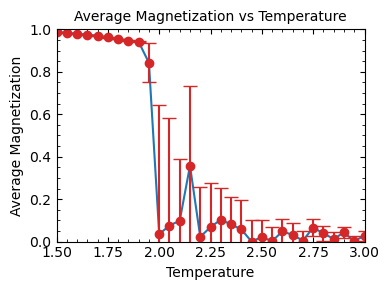

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(temperatures,np.abs(avg_magnetization))
plt.errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=5,color='tab:red')
plt.ylim([0,1])
plt.xlim([temperatures.min(), temperatures.max()])
plt.xlabel('Temperature')   
plt.ylabel('Average Magnetization')
plt.title('Average Magnetization vs Temperature',fontsize=10)
plt.minorticks_on()
ax=plt.gca()
ax.tick_params(which='both', direction='in', top=True, right=True)
plt.tight_layout()
# plt.savefig('avg_magnetization_vs_temperature.png', dpi=300)

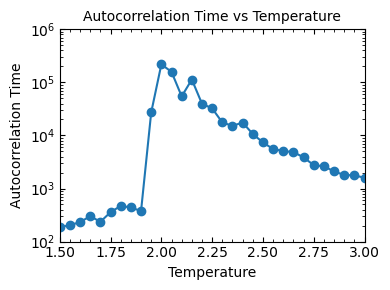

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(temperatures, autocorr_time_list, 'o-')
plt.yscale('log')
plt.ylim([1e2, 1e6])
plt.xlim([temperatures.min(), temperatures.max()])
plt.xlabel('Temperature')   
plt.ylabel('Autocorrelation Time')
plt.title('Autocorrelation Time vs Temperature',fontsize=10)
plt.minorticks_on()
ax=plt.gca()
ax.tick_params(which='both', direction='in', top=True, right=True)
plt.tight_layout()
# plt.savefig('autocorr_time_vs_temperature.png', dpi=300)

In [3]:
# Retry the simulation after restoring module files
from lattice import Lattice
from monte_carlo import MonteCarlo
from accumulator import Accumulator

# --- Analysis Functions ---
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n - 1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

# --- Simulation Parameters ---
temperatures = np.linspace(0.1, 10.0, 60)
rows, cols = 20, 20
doping = 0.3
kf = 0.3
J0 = -1.0
warmup_steps=100_000
steps = 1_000_000

susceptibilities = []
susceptibility_errors = []
magnetizations = []
magnetization_errors = []
autocorr_times = []

for T in temperatures:
    lattice = Lattice(rows, cols, doping, kf=kf, J0=J0)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method="metropolis")

    mags = mc.acc.magnetization
    tau = autocorr_time(autocorr(mags))

    magnetizations.append(np.mean(mags))
    magnetization_errors.append(mc.acc.calculate_error(mags, tau))

    chi = mc.acc.compute_susceptibility(mags, T, lattice.N)
    susceptibilities.append(chi)
    susceptibility_errors.append(mc.acc.calculate_error(susceptibilities, tau))

    autocorr_times.append(tau)


/home/lisa/Desktop/projects/monte-carlo-PtSe2/lattice.py:69: RuntimeWarning: invalid value encountered in multiply
  j1(self.kf * distances) * y1(self.kf * distances)


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107944.63it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30889.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140182.83it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30350.17it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139082.22it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30126.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140416.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30859.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139329.86it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30712.88it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141789.90it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30356.91it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139306.68it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30456.78it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141703.58it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29920.07it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139370.98it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30120.51it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140429.47it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30530.73it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 138245.88it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29958.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141763.35it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30174.58it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139383.20it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30437.67it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141885.59it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29725.43it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139590.51it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30022.18it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142776.41it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30014.60it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140216.86it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30293.09it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 138674.39it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30361.76it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 137422.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29897.66it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140383.18it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29868.62it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139630.94it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30387.04it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141800.01it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:34<00:00, 29392.95it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140120.17it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30638.16it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141314.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29876.67it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139646.24it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30359.98it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141616.88it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29621.14it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139112.35it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30415.85it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141282.72it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30211.99it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140571.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30278.24it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140497.87it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29741.35it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141469.95it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30519.48it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142736.47it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29968.65it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140132.02it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30743.87it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140272.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30349.37it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 136483.93it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29858.16it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142012.22it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29786.45it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 137836.68it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29557.25it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140055.28it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30551.22it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139346.30it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30383.36it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141533.11it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29523.76it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140241.80it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30422.03it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141028.76it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29852.94it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140297.20it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30195.32it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 138654.95it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30323.74it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140399.91it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30203.22it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140265.48it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:34<00:00, 29010.25it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140708.75it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30099.99it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 139188.29it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30033.06it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142880.49it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:34<00:00, 29353.49it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142475.32it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30156.07it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 141520.74it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29889.78it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142648.80it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30570.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 133580.90it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29592.13it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140663.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30089.17it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140525.88it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30247.83it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140201.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30243.72it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140068.84it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29899.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140900.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 29781.53it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 140756.39it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:33<00:00, 30187.03it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 142987.02it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:32<00:00, 30313.83it/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = -1.0
steps = 1_000_000  # production steps after warmup
warmup_steps = 100_000  # warmup steps
method = "metropolis"

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 66251.76it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:21<00:00, 47083.05it/s]


Average Magnetization: 0.9868 ± 0.0005
autocorr_time 187.1862

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106577.77it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53777.95it/s]


Average Magnetization: -0.9836 ± 0.0006
autocorr_time 203.1320

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105264.61it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53843.81it/s]


Average Magnetization: 0.9791 ± 0.0007
autocorr_time 234.0320

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106522.95it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55073.75it/s]


Average Magnetization: -0.9746 ± 0.0010
autocorr_time 300.1593

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107873.69it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53735.50it/s]


Average Magnetization: -0.9699 ± 0.0009
autocorr_time 236.2155

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111509.03it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55355.46it/s]


Average Magnetization: -0.9621 ± 0.0014
autocorr_time 358.5045

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107237.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54422.29it/s]


Average Magnetization: 0.9547 ± 0.0019
autocorr_time 470.3909

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105181.95it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54462.23it/s]


Average Magnetization: -0.9474 ± 0.0020
autocorr_time 438.9346

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110435.33it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53016.61it/s]


Average Magnetization: -0.9408 ± 0.0019
autocorr_time 376.4854

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 90078.53it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54337.89it/s]


Average Magnetization: -0.8424 ± 0.0914
autocorr_time 27072.7442

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108653.66it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54001.59it/s]


Average Magnetization: -0.0352 ± 0.6073
autocorr_time 219130.7471

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108237.70it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53701.58it/s]


Average Magnetization: -0.0753 ± 0.5065
autocorr_time 157919.3790

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103659.20it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:17<00:00, 56533.86it/s]


Average Magnetization: 0.0986 ± 0.2914
autocorr_time 54589.2030

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108480.19it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55105.51it/s]


Average Magnetization: 0.3572 ± 0.3763
autocorr_time 113139.8753

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100887.23it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55498.66it/s]


Average Magnetization: -0.0217 ± 0.2359
autocorr_time 39588.1613

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105034.93it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55554.92it/s]


Average Magnetization: -0.0684 ± 0.2070
autocorr_time 32397.3214

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111680.14it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55100.83it/s]


Average Magnetization: -0.1033 ± 0.1475
autocorr_time 17588.9541

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107329.15it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55172.88it/s]


Average Magnetization: 0.0807 ± 0.1305
autocorr_time 15141.1026

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104812.74it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54458.63it/s]


Average Magnetization: -0.0595 ± 0.1366
autocorr_time 17549.3942

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109471.35it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53894.34it/s]


Average Magnetization: -0.0008 ± 0.1014
autocorr_time 10679.2561

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109938.12it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54938.22it/s]


Average Magnetization: -0.0191 ± 0.0798
autocorr_time 7532.1746

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 97958.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:17<00:00, 56176.78it/s]


Average Magnetization: -0.0221 ± 0.0662
autocorr_time 5684.1412

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110552.23it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54132.81it/s]


Average Magnetization: -0.0484 ± 0.0604
autocorr_time 5073.3698

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 113574.47it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54919.02it/s]


Average Magnetization: 0.0756 ± 0.0524
autocorr_time 4192.4253

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109913.57it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54424.23it/s]


Average Magnetization: 0.0312 ± 0.0423
autocorr_time 3200.0664

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104923.68it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55054.27it/s]


Average Magnetization: 0.0315 ± 0.0498
autocorr_time 4480.0082

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111722.89it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54508.79it/s]


Average Magnetization: -0.0009 ± 0.0324
autocorr_time 2264.1050

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99931.67it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54750.58it/s]


Average Magnetization: -0.0287 ± 0.0309
autocorr_time 2247.3520

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111387.20it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53730.20it/s]


Average Magnetization: 0.0143 ± 0.0285
autocorr_time 1995.3204

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 113125.64it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54556.84it/s]


Average Magnetization: -0.0098 ± 0.0249
autocorr_time 1652.0405

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103528.71it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54562.08it/s]


Average Magnetization: 0.0058 ± 0.0214
autocorr_time 1383.8867


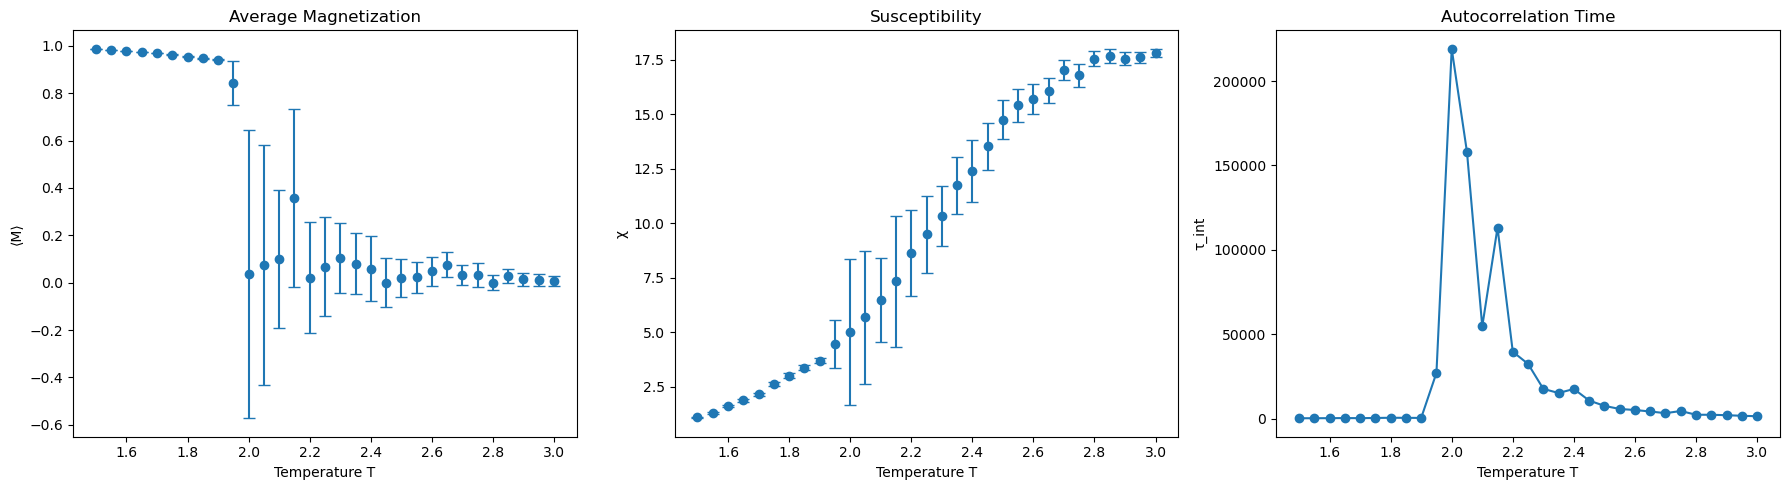

In [6]:
import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_title("Average Magnetization")

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


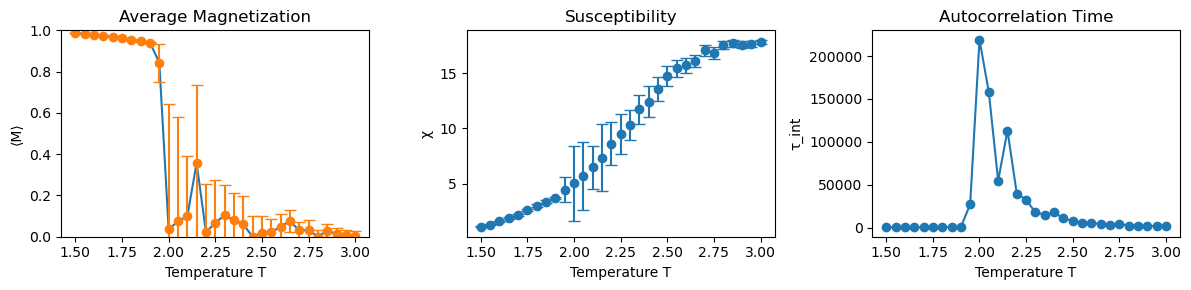

In [ ]:
# plt.figure(figsize=(4, 3))
# plt.plot(temperatures,np.abs(avg_magnetization))
# plt.errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=5,color='tab:red')
# plt.ylim([0,1])
# plt.xlim([temperatures.min(), temperatures.max()])
# plt.xlabel('Temperature')   
# plt.ylabel('Average Magnetization')
# plt.title('Average Magnetization vs Temperature',fontsize=10)
# plt.minorticks_on()
# ax=plt.gca()
# ax.tick_params(which='both', direction='in', top=True, right=True)
# plt.tight_layout()
# # plt.savefig('avg_magnetization_vs_temperature.png', dpi=300)

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = 1.0
steps = 1_00_000  # production steps after warmup
warmup_steps = 10_000  # warmup steps
method = "wolff"

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 5700.43it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:16<00:00, 6158.65it/s]


Average Magnetization: -0.0002 ± 0.0044
autocorr_time 1.0000

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6150.83it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:16<00:00, 6226.12it/s]


Average Magnetization: 0.0002 ± 0.0044
autocorr_time 1.0000

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6242.12it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:16<00:00, 6160.08it/s]


Average Magnetization: -0.0001 ± 0.0044
autocorr_time 1.0000

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6287.01it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:16<00:00, 6231.82it/s]


Average Magnetization: 0.0008 ± 0.0044
autocorr_time 1.0000

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6236.39it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6255.02it/s]


Average Magnetization: 0.0003 ± 0.0043
autocorr_time 1.0000

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6324.98it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6320.12it/s]


Average Magnetization: 0.0005 ± 0.0043
autocorr_time 1.0000

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6243.34it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6342.99it/s]


Average Magnetization: -0.0010 ± 0.0043
autocorr_time 1.0000

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6459.62it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6400.64it/s]


Average Magnetization: -0.0002 ± 0.0043
autocorr_time 1.0000

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6479.19it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6460.73it/s]


Average Magnetization: 0.0004 ± 0.0042
autocorr_time 1.0000

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6622.55it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6620.23it/s]


Average Magnetization: -0.0009 ± 0.0042
autocorr_time 1.0000

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 6614.82it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:15<00:00, 6664.70it/s]


Average Magnetization: -0.0007 ± 0.0041
autocorr_time 1.0000

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 7208.37it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:14<00:00, 6969.31it/s]


Average Magnetization: -0.0009 ± 0.0040
autocorr_time 1.0000

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 7185.06it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:14<00:00, 6938.30it/s]


Average Magnetization: -0.0008 ± 0.0040
autocorr_time 1.0000

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 7481.76it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:13<00:00, 7346.34it/s]


Average Magnetization: -0.0017 ± 0.0039
autocorr_time 1.0000

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 7777.20it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:13<00:00, 7664.07it/s]


Average Magnetization: 0.0009 ± 0.0038
autocorr_time 1.0000

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 8643.50it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:12<00:00, 7979.89it/s]


Average Magnetization: 0.0012 ± 0.0037
autocorr_time 1.0000

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 8496.04it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:11<00:00, 8523.26it/s]


Average Magnetization: 0.0026 ± 0.0035
autocorr_time 1.0000

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 9952.30it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:11<00:00, 9056.11it/s]


Average Magnetization: -0.0005 ± 0.0034
autocorr_time 1.0000

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 10000/10000 [00:01<00:00, 9837.20it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:10<00:00, 9644.11it/s]


Average Magnetization: -0.0007 ± 0.0032
autocorr_time 1.0000

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 11536.34it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:09<00:00, 10375.24it/s]


Average Magnetization: 0.0011 ± 0.0031
autocorr_time 1.0000

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 12017.52it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:08<00:00, 11128.61it/s]


Average Magnetization: 0.0006 ± 0.0029
autocorr_time 1.0000

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 13483.24it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:08<00:00, 11886.82it/s]


Average Magnetization: -0.0007 ± 0.0028
autocorr_time 1.0000

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 14318.63it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:07<00:00, 12810.17it/s]


Average Magnetization: -0.0011 ± 0.0027
autocorr_time 1.0000

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 16154.61it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:07<00:00, 13780.67it/s]


Average Magnetization: 0.0020 ± 0.0025
autocorr_time 1.0000

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 16423.00it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:06<00:00, 14544.02it/s]


Average Magnetization: -0.0015 ± 0.0024
autocorr_time 1.0000

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 18621.61it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:06<00:00, 15424.17it/s]


Average Magnetization: -0.0028 ± 0.0023
autocorr_time 1.0000

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 19658.25it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:06<00:00, 16555.97it/s]


Average Magnetization: -0.0019 ± 0.0024
autocorr_time 1.1568

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 21199.92it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:05<00:00, 17642.26it/s]


Average Magnetization: 0.0027 ± 0.0024
autocorr_time 1.3264

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 21989.70it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:05<00:00, 18706.48it/s]


Average Magnetization: -0.0003 ± 0.0024
autocorr_time 1.4280

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 24691.68it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:05<00:00, 19601.76it/s]


Average Magnetization: 0.0006 ± 0.0024
autocorr_time 1.5637

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 24815.83it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:04<00:00, 20549.60it/s]

Average Magnetization: 0.0010 ± 0.0025
autocorr_time 1.8682


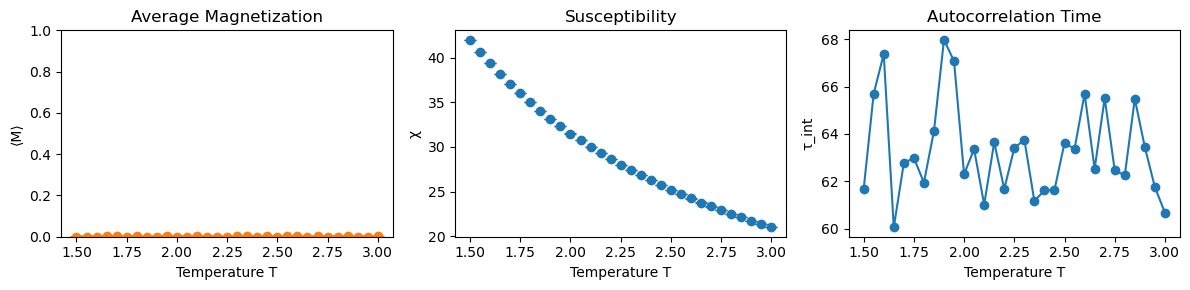

In [5]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


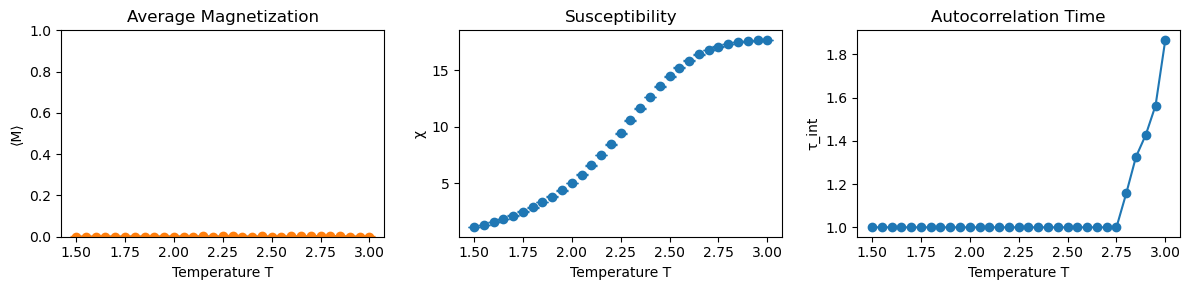

In [7]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [1]:
from monte_carlo import MonteCarlo
from ising_lattice import IsingLattice  # Replace with your actual lattice module
from visualization import Visualization

# Parameters
Lx, Ly = 32, 32
T = 2.3
warmup_steps = 500
production_steps = 10

# Set up lattice and simulation
lattice = IsingLattice(Lx, Ly, J=1.0)  # Ensure constructor matches yours
mc = MonteCarlo(lattice)

# Run simulation with visualization
mc.run_loop(warmup_steps=warmup_steps, steps=production_steps, T=T, method="wolff")

# Create animated GIF from saved frames
Visualization.create_gif_from_frames(output_dir="frames", output_file="ising_evolution.gif", fps=5)


Starting warmup phase...


100%|██████████| 500/500 [00:24<00:00, 20.23it/s]


Starting production phase...


100%|██████████| 10/10 [00:00<00:00, 274.44it/s]


GIF saved to ising_evolution.gif


In [1]:
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo
from visualization import Visualization

rows, cols = 20, 20
lattice = IsingLattice(rows, cols)

mc = MonteCarlo(lattice)
warmup_steps     = 100
production_steps = 5
T = 2.0  # pick your temperature

mc.run_loop(warmup_steps, production_steps, T,
            method="wolff")

Visualization.create_gif_from_frames()   


Starting warmup phase...


100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


GIF saved to ising_warmup.gif
Starting production phase...


100%|██████████| 5/5 [00:00<00:00, 1024.15it/s]


GIF saved to ising_simulation.gif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8 
J = -1.0
steps = 1_000_000  # production steps after warmup
warmup_steps = 100_000  # warmup steps
method = "metropolis"    ##  wolff

# --- Storage ---
avg_magnetization_m = []
magnetization_errors_m = []
susceptibilities_m = []
susceptibility_errors_m = []
autocorr_time_list_m = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112668.63it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54192.00it/s]


Average Magnetization: 0.9868 ± 0.0005
autocorr_time 187.6023

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106399.11it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55134.99it/s]


Average Magnetization: -0.9836 ± 0.0006
autocorr_time 203.1292

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108519.45it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53894.01it/s]


Average Magnetization: -0.9791 ± 0.0007
autocorr_time 234.0465

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106170.21it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53381.27it/s]


Average Magnetization: -0.9746 ± 0.0010
autocorr_time 300.2417

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111436.36it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55087.57it/s]


Average Magnetization: 0.9700 ± 0.0009
autocorr_time 236.2827

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105265.29it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55141.40it/s]


Average Magnetization: -0.9621 ± 0.0014
autocorr_time 358.4977

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105545.89it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53102.26it/s]


Average Magnetization: 0.9547 ± 0.0019
autocorr_time 470.3837

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105070.45it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54979.74it/s]


Average Magnetization: -0.9474 ± 0.0020
autocorr_time 438.9352

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110775.91it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54724.96it/s]


Average Magnetization: 0.9408 ± 0.0019
autocorr_time 376.6682

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104056.39it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55237.91it/s]


Average Magnetization: 0.8424 ± 0.0916
autocorr_time 27203.7436

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105699.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54140.61it/s]


Average Magnetization: -0.0352 ± 0.6074
autocorr_time 219159.8320

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105530.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:19<00:00, 52301.50it/s]


Average Magnetization: -0.0753 ± 0.5064
autocorr_time 157851.8723

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 95260.96it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55456.71it/s]


Average Magnetization: 0.0984 ± 0.2914
autocorr_time 54582.8028

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110649.32it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53180.93it/s]


Average Magnetization: -0.3572 ± 0.3763
autocorr_time 113140.8397

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104226.30it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54606.30it/s]


Average Magnetization: -0.0223 ± 0.2360
autocorr_time 39609.1005

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103956.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55436.64it/s]


Average Magnetization: 0.0681 ± 0.2071
autocorr_time 32402.6695

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112071.80it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55253.80it/s]


Average Magnetization: 0.1033 ± 0.1475
autocorr_time 17582.0702

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106898.02it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54097.67it/s]


Average Magnetization: -0.0807 ± 0.1305
autocorr_time 15138.4208

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 97241.61it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53972.58it/s]


Average Magnetization: -0.0599 ± 0.1366
autocorr_time 17556.7054

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105903.88it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:17<00:00, 55645.48it/s]


Average Magnetization: -0.0006 ± 0.1014
autocorr_time 10673.8267

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110986.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55042.25it/s]


Average Magnetization: -0.0216 ± 0.0790
autocorr_time 7396.8440

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 114562.50it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:17<00:00, 55717.95it/s]


Average Magnetization: 0.0198 ± 0.0648
autocorr_time 5514.5257

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107502.98it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:17<00:00, 56067.87it/s]


Average Magnetization: -0.0466 ± 0.0665
autocorr_time 6252.7567

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110215.74it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54743.03it/s]


Average Magnetization: -0.0988 ± 0.0561
autocorr_time 4853.5817

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108569.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55342.77it/s]


Average Magnetization: 0.0098 ± 0.0424
autocorr_time 3177.0133

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110451.44it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53204.91it/s]


Average Magnetization: -0.0464 ± 0.0401
autocorr_time 3165.2818

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 88501.30it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54838.72it/s]


Average Magnetization: 0.0109 ± 0.0352
autocorr_time 2679.3110

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 97769.51it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 55075.22it/s]


Average Magnetization: 0.0120 ± 0.0328
autocorr_time 2570.1048

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96792.98it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54604.94it/s]


Average Magnetization: -0.0209 ± 0.0292
autocorr_time 2084.3620

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106714.13it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 53944.08it/s]


Average Magnetization: 0.0241 ± 0.0258
autocorr_time 1779.1262

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106413.20it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:18<00:00, 54996.27it/s]


Average Magnetization: 0.0100 ± 0.0227
autocorr_time 1566.5293


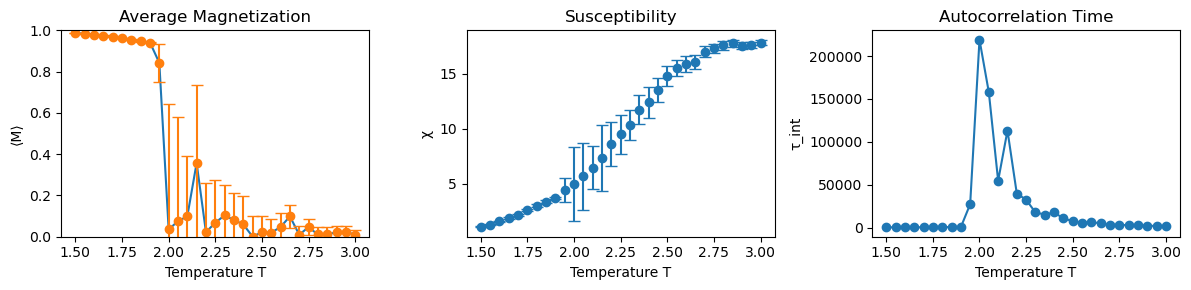

In [3]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = -1.0 
steps = 1_00_000  # production steps after warmup
warmup_steps = 10_000  # warmup steps
method = "metropolis"    ##  wolff

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 65338.96it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:02<00:00, 49760.09it/s]


Average Magnetization: -0.9848 ± 0.0020
autocorr_time 266.0710

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 106052.28it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54256.71it/s]


Average Magnetization: -0.9818 ± 0.0022
autocorr_time 238.4939

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 97269.60it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 50465.42it/s]


Average Magnetization: 0.9743 ± 0.0049
autocorr_time 495.4270

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 107625.18it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 52512.51it/s]


Average Magnetization: 0.9690 ± 0.0058
autocorr_time 517.9903

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 74850.97it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54219.72it/s]


Average Magnetization: -0.9668 ± 0.0038
autocorr_time 278.7139

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 101733.62it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53273.05it/s]


Average Magnetization: -0.5844 ± 0.4834
autocorr_time 20728.4816

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 72033.17it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54931.06it/s]


Average Magnetization: -0.9515 ± 0.0081
autocorr_time 545.6591

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 96354.11it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 50268.47it/s]


Average Magnetization: 0.9540 ± 0.0041
autocorr_time 260.5726

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 75202.86it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54841.19it/s]


Average Magnetization: -0.9428 ± 0.0044
autocorr_time 252.3971

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 110658.60it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54813.40it/s]


Average Magnetization: 0.9135 ± 0.0116
autocorr_time 608.8036

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 99954.10it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54176.33it/s]


Average Magnetization: -0.9206 ± 0.0064
autocorr_time 323.1049

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 114516.49it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54695.60it/s]


Average Magnetization: -0.2426 ± 0.4442
autocorr_time 13682.3541

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 95184.48it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53817.86it/s]


Average Magnetization: -0.6859 ± 0.2491
autocorr_time 10574.9005

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 108580.84it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54714.14it/s]


Average Magnetization: -0.6659 ± 0.2778
autocorr_time 12028.6413

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 92886.81it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 51921.46it/s]


Average Magnetization: 0.8360 ± 0.0143
autocorr_time 477.2057

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 91274.57it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 51069.27it/s]


Average Magnetization: -0.0017 ± 0.4443
autocorr_time 14746.6676

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 109636.66it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55320.18it/s]


Average Magnetization: -0.5628 ± 0.2141
autocorr_time 7899.7730

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 94432.70it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55338.01it/s]


Average Magnetization: 0.2988 ± 0.4323
autocorr_time 20076.6686

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 101414.82it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55382.16it/s]


Average Magnetization: 0.2122 ± 0.2965
autocorr_time 8859.3868

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 110441.81it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53028.04it/s]


Average Magnetization: -0.2590 ± 0.2088
autocorr_time 5566.7069

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 75276.69it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55776.90it/s]


Average Magnetization: 0.2603 ± 0.1563
autocorr_time 3732.8568

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 107980.11it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54830.03it/s]


Average Magnetization: -0.0404 ± 0.2070
autocorr_time 5791.1847

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 106003.50it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55490.49it/s]


Average Magnetization: -0.0902 ± 0.1538
autocorr_time 3715.4159

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 84327.11it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 50617.63it/s]


Average Magnetization: 0.1622 ± 0.1195
autocorr_time 2612.2398

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 67337.38it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53887.72it/s]


Average Magnetization: -0.1072 ± 0.1145
autocorr_time 2429.0609

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 87142.24it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54498.84it/s]


Average Magnetization: -0.0790 ± 0.1330
autocorr_time 3451.6890

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 111095.32it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55117.36it/s]


Average Magnetization: 0.0373 ± 0.1080
autocorr_time 2302.0443

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 111209.91it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54985.73it/s]


Average Magnetization: 0.0316 ± 0.0781
autocorr_time 1547.6303

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 96739.47it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53589.00it/s]


Average Magnetization: -0.0065 ± 0.0879
autocorr_time 2021.9557

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 114313.00it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53926.00it/s]


Average Magnetization: 0.0256 ± 0.0842
autocorr_time 1866.6286

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 110518.06it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 56172.15it/s]


Average Magnetization: 0.0849 ± 0.0654
autocorr_time 1400.4792


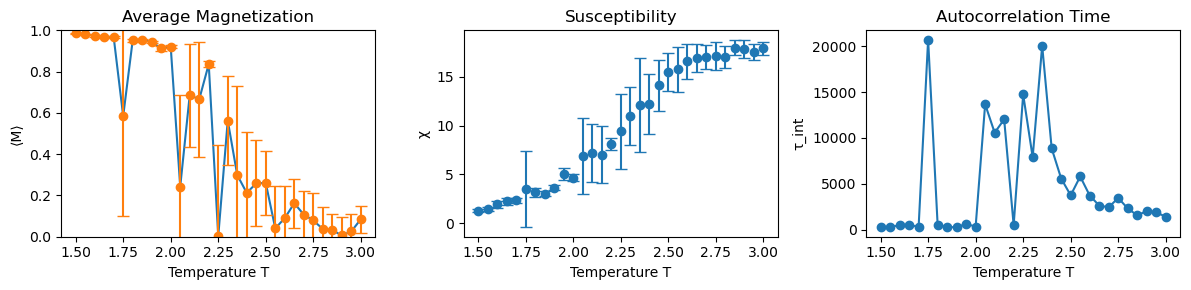

In [5]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = -1.0 
steps = 1_00_000  # production steps after warmup
warmup_steps = 10_000  # warmup steps
method = "metropolis"    ##  wolff

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 80941.27it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54353.87it/s]


Average Magnetization: 0.9848 ± 0.0020
autocorr_time 266.2087

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 107773.69it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53603.58it/s]


Average Magnetization: 0.9818 ± 0.0022
autocorr_time 238.1291

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 101835.38it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53510.87it/s]


Average Magnetization: -0.9743 ± 0.0049
autocorr_time 495.0893

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 96759.10it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54796.19it/s]


Average Magnetization: -0.9690 ± 0.0058
autocorr_time 517.7241

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 109116.98it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55402.17it/s]


Average Magnetization: 0.9668 ± 0.0038
autocorr_time 278.7102

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 80543.52it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54661.63it/s]


Average Magnetization: 0.5824 ± 0.4855
autocorr_time 20840.3662

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 100081.46it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53948.07it/s]


Average Magnetization: -0.9515 ± 0.0081
autocorr_time 545.8250

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 98175.76it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53133.65it/s]


Average Magnetization: 0.9540 ± 0.0041
autocorr_time 260.3319

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 95876.60it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 52624.68it/s]


Average Magnetization: -0.9428 ± 0.0044
autocorr_time 251.9805

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 103365.52it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 51868.87it/s]


Average Magnetization: -0.9135 ± 0.0116
autocorr_time 608.7743

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 85346.36it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54327.70it/s]


Average Magnetization: -0.9205 ± 0.0064
autocorr_time 322.5225

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 96957.73it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54769.71it/s]


Average Magnetization: -0.2437 ± 0.4439
autocorr_time 13670.3508

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 101006.96it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54174.93it/s]


Average Magnetization: 0.6848 ± 0.2503
autocorr_time 10631.6643

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 67937.37it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54251.09it/s]


Average Magnetization: -0.6603 ± 0.2845
autocorr_time 12341.3848

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 102612.19it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54986.08it/s]


Average Magnetization: 0.8363 ± 0.0142
autocorr_time 472.6645

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 65754.22it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55543.73it/s]


Average Magnetization: 0.0026 ± 0.4443
autocorr_time 14744.7717

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 102470.05it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53086.80it/s]


Average Magnetization: 0.5605 ± 0.2139
autocorr_time 7806.7801

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 92877.56it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54279.63it/s]


Average Magnetization: 0.2479 ± 0.3950
autocorr_time 16573.7090

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 105575.78it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54651.06it/s]


Average Magnetization: 0.3040 ± 0.1942
autocorr_time 4552.6491

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 113749.70it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55805.47it/s]


Average Magnetization: -0.2593 ± 0.2069
autocorr_time 5464.8151

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 95901.81it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55335.42it/s]


Average Magnetization: -0.0504 ± 0.2297
autocorr_time 6149.3538

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 98118.34it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55771.91it/s]


Average Magnetization: -0.0816 ± 0.1960
autocorr_time 4703.4387

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 88923.98it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 52805.26it/s]


Average Magnetization: 0.1444 ± 0.1435
autocorr_time 3047.3585

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 93939.69it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55388.24it/s]


Average Magnetization: -0.0405 ± 0.1662
autocorr_time 3872.3804

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 105119.61it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55741.07it/s]


Average Magnetization: 0.1642 ± 0.1143
autocorr_time 2800.3303

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 106194.86it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 51496.93it/s]


Average Magnetization: -0.0710 ± 0.1032
autocorr_time 2445.5916

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 102907.76it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 54499.25it/s]


Average Magnetization: -0.1515 ± 0.1038
autocorr_time 2299.1966

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 96905.53it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55036.24it/s]


Average Magnetization: 0.0314 ± 0.0933
autocorr_time 1992.2253

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 64595.73it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55961.32it/s]


Average Magnetization: -0.1061 ± 0.0929
autocorr_time 2242.9518

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 100789.73it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 55938.64it/s]


Average Magnetization: 0.0123 ± 0.0916
autocorr_time 2344.6398

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 10000/10000 [00:00<00:00, 113502.52it/s]


Starting production phase...


100%|██████████| 100000/100000 [00:01<00:00, 53903.47it/s]

Average Magnetization: 0.0241 ± 0.0787
autocorr_time 1659.4023


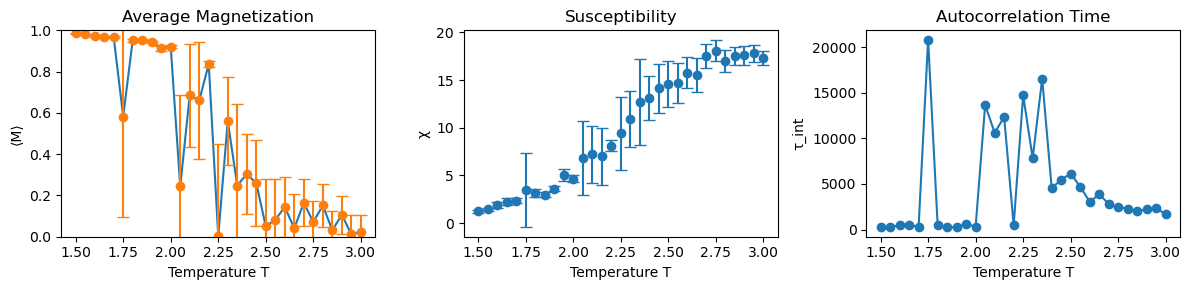

In [7]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = 1.0 
steps = 1_000  # production steps after warmup
warmup_steps = 100  # warmup steps
method = "wolff"    ##  wolff   metropolis

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)

    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3703.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4321.67it/s]


Average Magnetization: -0.0061 ± 0.0441
autocorr_time 1.0000

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6683.51it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6199.78it/s]


Average Magnetization: 0.0018 ± 0.0441
autocorr_time 1.0000

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6414.98it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6128.85it/s]


Average Magnetization: -0.0000 ± 0.0437
autocorr_time 1.0000

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6650.34it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6114.06it/s]


Average Magnetization: -0.0008 ± 0.0437
autocorr_time 1.0000

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6828.67it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6081.38it/s]


Average Magnetization: 0.0077 ± 0.0434
autocorr_time 1.0000

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5981.86it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6286.57it/s]


Average Magnetization: 0.0012 ± 0.0431
autocorr_time 1.0000

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6370.93it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6184.66it/s]


Average Magnetization: -0.0027 ± 0.0429
autocorr_time 1.0000

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6722.07it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6222.77it/s]


Average Magnetization: 0.0107 ± 0.0425
autocorr_time 1.0000

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6844.71it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6198.04it/s]


Average Magnetization: 0.0018 ± 0.0420
autocorr_time 1.0000

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6527.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6210.14it/s]


Average Magnetization: 0.0061 ± 0.0417
autocorr_time 1.0000

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7067.66it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6718.63it/s]


Average Magnetization: -0.0041 ± 0.0409
autocorr_time 1.0000

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7262.86it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6995.73it/s]


Average Magnetization: -0.0024 ± 0.0401
autocorr_time 1.0000

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7664.19it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6887.13it/s]


Average Magnetization: 0.0049 ± 0.0393
autocorr_time 1.0000

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7096.96it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7040.91it/s]


Average Magnetization: 0.0159 ± 0.0384
autocorr_time 1.0000

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8120.63it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7522.75it/s]


Average Magnetization: -0.0049 ± 0.0373
autocorr_time 1.0000

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8094.92it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8305.44it/s]


Average Magnetization: 0.0025 ± 0.0360
autocorr_time 1.0000

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9770.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8622.09it/s]


Average Magnetization: -0.0126 ± 0.0348
autocorr_time 1.0000

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9577.35it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8886.61it/s]


Average Magnetization: -0.0091 ± 0.0337
autocorr_time 1.0000

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10484.71it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9731.93it/s]


Average Magnetization: 0.0066 ± 0.0319
autocorr_time 1.0000

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9898.53it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10057.27it/s]


Average Magnetization: 0.0037 ± 0.0307
autocorr_time 1.0000

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11038.80it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10481.78it/s]


Average Magnetization: -0.0016 ± 0.0290
autocorr_time 1.0000

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12375.86it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11816.80it/s]


Average Magnetization: -0.0117 ± 0.0277
autocorr_time 1.0000

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 13234.17it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13268.71it/s]


Average Magnetization: 0.0127 ± 0.0258
autocorr_time 1.0000

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15142.99it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13553.75it/s]


Average Magnetization: 0.0053 ± 0.0249
autocorr_time 1.0000

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14240.18it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14200.36it/s]


Average Magnetization: -0.0049 ± 0.0238
autocorr_time 1.0000

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 17095.88it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14603.97it/s]


Average Magnetization: 0.0309 ± 0.0228
autocorr_time 1.0000

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 16179.23it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16063.85it/s]


Average Magnetization: 0.0178 ± 0.0240
autocorr_time 1.2478

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20275.07it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17086.06it/s]


Average Magnetization: 0.0440 ± 0.0233
autocorr_time 1.3163

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21231.61it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 19156.45it/s]


Average Magnetization: -0.0108 ± 0.0245
autocorr_time 1.5591

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20777.25it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18644.25it/s]


Average Magnetization: -0.0036 ± 0.0234
autocorr_time 1.6312

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21508.15it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 19977.92it/s]

Average Magnetization: -0.0303 ± 0.0244
autocorr_time 1.8806


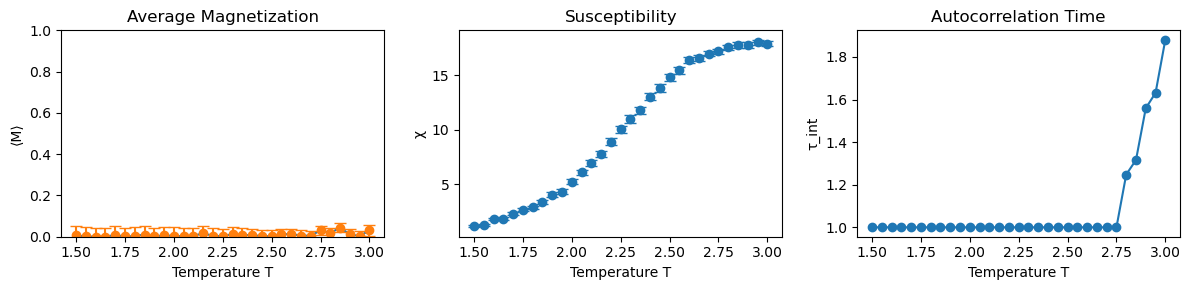

In [9]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
axs[1].set_title("Susceptibility")

axs[2].plot(temperatures, autocorr_time_list, marker='o')
# axs[2].set_yscale('log')
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel("τ_int")
axs[2].set_title("Autocorrelation Time")
# plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = 1.0 
steps = 1_000  # production steps after warmup
warmup_steps = 100  # warmup steps
method = "wolff"    ##  wolff   metropolis

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
m2_array = []
m2_errors = []

def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)
    m2_vals = acc.m2_array
    m2_err = acc.calculate_error(m2_vals,tau)


    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)

    m2_array.append(np.mean(m2_vals))
    

    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))
    m2_errors.append(m2_err)


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8771.21it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8211.31it/s]


Average Magnetization: 0.0037 ± 0.0441
autocorr_time 1.0000

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9387.22it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8320.55it/s]


Average Magnetization: -0.0007 ± 0.0440
autocorr_time 1.0000

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8246.44it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8263.42it/s]


Average Magnetization: 0.0040 ± 0.0438
autocorr_time 1.0000

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9421.80it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8413.34it/s]


Average Magnetization: -0.0034 ± 0.0436
autocorr_time 1.0000

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9628.80it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8502.08it/s]


Average Magnetization: -0.0076 ± 0.0433
autocorr_time 1.0000

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9176.10it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8155.24it/s]


Average Magnetization: 0.0012 ± 0.0431
autocorr_time 1.0000

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8430.59it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7419.38it/s]


Average Magnetization: 0.0027 ± 0.0429
autocorr_time 1.0000

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9123.41it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8246.20it/s]


Average Magnetization: -0.0131 ± 0.0424
autocorr_time 1.0000

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9264.47it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8306.31it/s]


Average Magnetization: -0.0116 ± 0.0421
autocorr_time 1.0000

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9664.07it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8524.99it/s]


Average Magnetization: -0.0017 ± 0.0417
autocorr_time 1.0000

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10033.02it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8281.72it/s]


Average Magnetization: -0.0000 ± 0.0408
autocorr_time 1.0000

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10069.87it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8769.28it/s]


Average Magnetization: 0.0043 ± 0.0401
autocorr_time 1.0000

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8755.10it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8783.20it/s]


Average Magnetization: 0.0047 ± 0.0394
autocorr_time 1.0000

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11073.49it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9200.84it/s]


Average Magnetization: -0.0035 ± 0.0380
autocorr_time 1.0000

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10123.59it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10181.56it/s]


Average Magnetization: 0.0227 ± 0.0371
autocorr_time 1.0000

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11593.84it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10374.08it/s]


Average Magnetization: 0.0031 ± 0.0359
autocorr_time 1.0000

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11943.46it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10748.20it/s]


Average Magnetization: -0.0043 ± 0.0347
autocorr_time 1.0000

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11409.66it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11120.55it/s]


Average Magnetization: 0.0062 ± 0.0338
autocorr_time 1.0000

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11008.09it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11197.50it/s]


Average Magnetization: -0.0146 ± 0.0322
autocorr_time 1.0000

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12596.64it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13004.91it/s]


Average Magnetization: 0.0038 ± 0.0304
autocorr_time 1.0000

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15414.00it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13232.08it/s]


Average Magnetization: 0.0032 ± 0.0290
autocorr_time 1.0000

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15606.13it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14091.59it/s]


Average Magnetization: 0.0148 ± 0.0279
autocorr_time 1.0000

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14970.03it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13850.54it/s]


Average Magnetization: 0.0012 ± 0.0255
autocorr_time 1.0000

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 19160.82it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 15855.80it/s]


Average Magnetization: 0.0121 ± 0.0248
autocorr_time 1.0000

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20101.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16551.85it/s]


Average Magnetization: 0.0040 ± 0.0237
autocorr_time 1.0000

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20613.87it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17170.91it/s]


Average Magnetization: -0.0200 ± 0.0265
autocorr_time 1.3338

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21182.28it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18191.02it/s]


Average Magnetization: -0.0170 ± 0.0248
autocorr_time 1.2982

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 22404.27it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18821.54it/s]


Average Magnetization: 0.0148 ± 0.0240
autocorr_time 1.3830

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 24830.12it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 20252.55it/s]


Average Magnetization: 0.0113 ± 0.0228
autocorr_time 1.3883

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 23771.84it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 19672.17it/s]


Average Magnetization: 0.0022 ± 0.0240
autocorr_time 1.6369

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 23914.16it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 20724.89it/s]

Average Magnetization: -0.0106 ± 0.0244
autocorr_time 1.9482


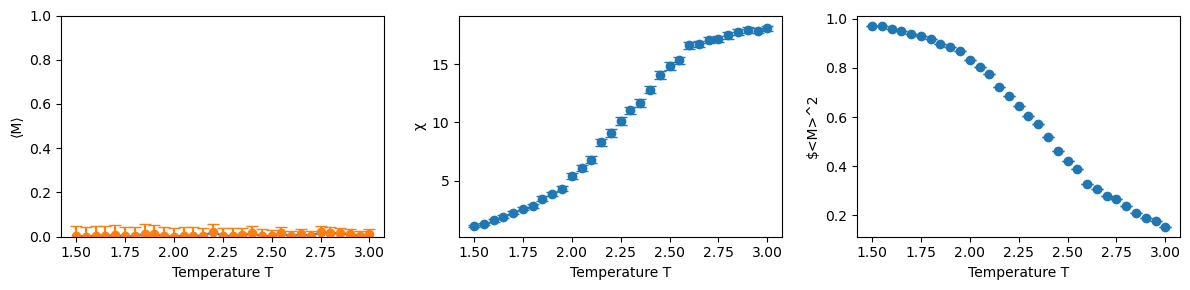

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
# axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
# axs[1].set_title("Susceptibility")


axs[2].errorbar(temperatures, m2_array, yerr=m2_errors, fmt='o', capsize=4)
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel(r'<M>^2')
# axs[2].set_title("Susceptibility")

# axs[2].plot(temperatures, autocorr_time_list, marker='o')
# # axs[2].set_yscale('log')
# axs[2].set_xlabel("Temperature T")
# axs[2].set_ylabel("τ_int")
# axs[2].set_title("Autocorrelation Time")
# # plt.savefig('100ksteps')
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo

temperatures = np.linspace(1.5, 3.0, 31)  # Temperature range
Lx = 8
Ly = 8
J = 1.0 
steps = 1_000  # production steps after warmup
warmup_steps = 100  # warmup steps
method = "wolff"    ##  wolff   metropolis

# --- Storage ---
avg_magnetization = []
magnetization_errors = []
susceptibilities = []
susceptibility_errors = []
autocorr_time_list = []
m2_array = []
m2_errors = []
mabs_array = []

def autocorr(x):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode='full')
    acov = result[n-1:]   # lags 0..n-1
    acov /= np.arange(n, 0, -1)   # unbiased: divide by N-k
    return acov / acov[0]         # normalize → acf[0]=1

def autocorr_time(correlation):
    for i, val in enumerate(correlation[1:], 1):
        if val < 0:
            return 1 + 2 * np.sum(correlation[1:i])
    return 1 + 2 * np.sum(correlation[1:])

def autocorr_fft(x, unbiased=True):
    """
    Compute autocorrelation of a 1D array using FFT (fast, O(n log n)).
    
    Returns:
        acf : array of length n (lags 0..n-1), normalized so acf[0] = 1.
    
    Parameters:
        unbiased : if True, normalize by (n - lag),
                   else normalize by n (biased).
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x = x - x.mean()

    # FFT length (next power of two >= 2n-1 for linear convolution)
    nfft = 1 << (2*n - 1).bit_length()

    # Power spectrum
    f = np.fft.rfft(x, n=nfft)
    acov = np.fft.irfft(f * np.conjugate(f), n=nfft)[:n]

    # Variance
    var = acov[0] / n

    # Normalize to get correlation
    if unbiased:
        denom = var * (n - np.arange(n))
    else:
        denom = var * n

    acf = acov / denom
    return acf

# --- Loop over temperatures ---
for T in temperatures:
    print(f"\nRunning Metropolis at T = {T:.2f}")

    lattice = IsingLattice(Lx, Ly, J=J)
    mc = MonteCarlo(lattice)
    mc.run_loop(warmup_steps=warmup_steps,steps=steps, T=T, method=method)

    acc = mc.acc  

    M_vals = np.asarray(acc.magnetization)
    M_mean = M_vals.mean()
    tau = acc.magnetization_tau_int
    M_err = acc.calculate_error(M_vals, tau)
    m2_vals = acc.m2_array
    m2_err = acc.calculate_error(m2_vals,tau)


    chi = np.mean(acc.susceptibility)
    # chi_err = acc.(M_vals, T, lattice.N)

    m2_array.append(np.mean(m2_vals))
    mabs_array.append(np.mean(acc.m_abs_array))
    acf=autocorr_fft(acc.magnetization)
    acf_time=autocorr_time(acf)
    autocorr_time_list.append(acf_time)  
    M_err=np.sqrt(np.var(acc.magnetization)*2*acf_time/len(acc.magnetization))
    chi_err=np.sqrt(np.var(acc.susceptibility)*2*acf_time/len(acc.susceptibility))
    m2_errors.append(m2_err)


    avg_magnetization.append(M_mean)
    magnetization_errors.append(M_err)
    susceptibilities.append(chi)
    susceptibility_errors.append(chi_err)
    print(f"Average Magnetization: {M_mean:.4f} ± {M_err:.4f}")
    print(f"autocorr_time {acf_time:.4f}")


Running Metropolis at T = 1.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5649.58it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7614.90it/s]


Average Magnetization: 0.0061 ± 0.0441
autocorr_time 1.0000

Running Metropolis at T = 1.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9326.27it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8165.35it/s]


Average Magnetization: 0.0019 ± 0.0441
autocorr_time 1.0000

Running Metropolis at T = 1.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9041.40it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8143.20it/s]


Average Magnetization: 0.0035 ± 0.0437
autocorr_time 1.0000

Running Metropolis at T = 1.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8142.54it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7865.20it/s]


Average Magnetization: 0.0034 ± 0.0436
autocorr_time 1.0000

Running Metropolis at T = 1.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8811.38it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7411.32it/s]


Average Magnetization: -0.0076 ± 0.0433
autocorr_time 1.0000

Running Metropolis at T = 1.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8846.69it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7549.21it/s]


Average Magnetization: -0.0076 ± 0.0432
autocorr_time 1.0000

Running Metropolis at T = 1.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7976.39it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8008.14it/s]


Average Magnetization: 0.0026 ± 0.0430
autocorr_time 1.0000

Running Metropolis at T = 1.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9586.10it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7942.52it/s]


Average Magnetization: -0.0114 ± 0.0425
autocorr_time 1.0000

Running Metropolis at T = 1.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8355.85it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8141.10it/s]


Average Magnetization: 0.0037 ± 0.0419
autocorr_time 1.0000

Running Metropolis at T = 1.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10230.76it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7991.56it/s]


Average Magnetization: 0.0061 ± 0.0417
autocorr_time 1.0000

Running Metropolis at T = 2.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8971.97it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8347.41it/s]


Average Magnetization: -0.0054 ± 0.0410
autocorr_time 1.0000

Running Metropolis at T = 2.05
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9059.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8815.14it/s]


Average Magnetization: 0.0062 ± 0.0399
autocorr_time 1.0000

Running Metropolis at T = 2.10
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9183.13it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8816.97it/s]


Average Magnetization: 0.0073 ± 0.0392
autocorr_time 1.0000

Running Metropolis at T = 2.15
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10895.99it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9468.72it/s]


Average Magnetization: -0.0107 ± 0.0381
autocorr_time 1.0000

Running Metropolis at T = 2.20
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9949.48it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10116.34it/s]


Average Magnetization: 0.0077 ± 0.0368
autocorr_time 1.0000

Running Metropolis at T = 2.25
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10864.95it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10044.58it/s]


Average Magnetization: 0.0018 ± 0.0361
autocorr_time 1.0000

Running Metropolis at T = 2.30
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11973.46it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11125.74it/s]


Average Magnetization: -0.0052 ± 0.0346
autocorr_time 1.0000

Running Metropolis at T = 2.35
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12053.64it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11347.43it/s]


Average Magnetization: -0.0180 ± 0.0339
autocorr_time 1.0000

Running Metropolis at T = 2.40
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12388.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12063.52it/s]


Average Magnetization: 0.0182 ± 0.0316
autocorr_time 1.0000

Running Metropolis at T = 2.45
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12838.79it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12738.50it/s]


Average Magnetization: -0.0191 ± 0.0305
autocorr_time 1.0000

Running Metropolis at T = 2.50
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14125.56it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13422.12it/s]


Average Magnetization: -0.0230 ± 0.0294
autocorr_time 1.0000

Running Metropolis at T = 2.55
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15419.67it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13944.66it/s]


Average Magnetization: 0.0200 ± 0.0272
autocorr_time 1.0000

Running Metropolis at T = 2.60
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 16771.18it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14800.94it/s]


Average Magnetization: -0.0090 ± 0.0263
autocorr_time 1.0000

Running Metropolis at T = 2.65
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 17478.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 15772.98it/s]


Average Magnetization: 0.0167 ± 0.0251
autocorr_time 1.0000

Running Metropolis at T = 2.70
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 19279.72it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16118.92it/s]


Average Magnetization: -0.0437 ± 0.0235
autocorr_time 1.0000

Running Metropolis at T = 2.75
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 17394.37it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17650.34it/s]


Average Magnetization: 0.0241 ± 0.0240
autocorr_time 1.1528

Running Metropolis at T = 2.80
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 19418.07it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17913.58it/s]


Average Magnetization: -0.0022 ± 0.0234
autocorr_time 1.1303

Running Metropolis at T = 2.85
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21416.99it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18501.72it/s]


Average Magnetization: 0.0018 ± 0.0222
autocorr_time 1.2134

Running Metropolis at T = 2.90
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 23454.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 19435.26it/s]


Average Magnetization: 0.0092 ± 0.0230
autocorr_time 1.4524

Running Metropolis at T = 2.95
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 22511.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 20975.09it/s]


Average Magnetization: -0.0068 ± 0.0245
autocorr_time 1.7311

Running Metropolis at T = 3.00
Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 22674.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 21415.24it/s]

Average Magnetization: 0.0103 ± 0.0244
autocorr_time 1.8259


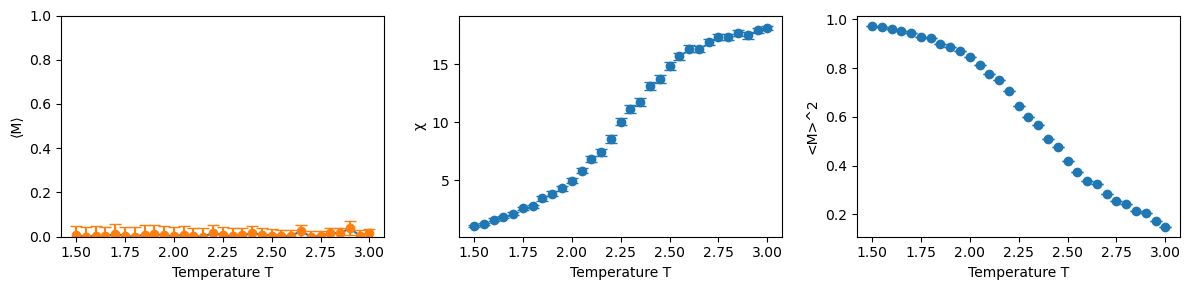

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(temperatures, np.abs(avg_magnetization))
axs[0].errorbar(temperatures, np.abs(avg_magnetization), yerr=magnetization_errors, fmt='o', capsize=4)
axs[0].set_xlabel("Temperature T")
axs[0].set_ylabel("⟨M⟩")
axs[0].set_ylim(0,1)
# axs[0].set_title("Average Magnetization")
# axs[0].tick_params(which='both', direction='in', top=True, right=True)

# axs[1].errorbar(temperatures, susceptibilities, yerr=susceptibility_errors, fmt='o', capsize=4)
# axs[1].set_xlabel("Temperature T")
# axs[1].set_ylabel("χ")
# # axs[1].set_title("Susceptibility")

axs[1].plot(temperatures, mabs_array, fmt='o', capsize=4)
axs[1].set_xlabel("Temperature T")
axs[1].set_ylabel("χ")
# axs[1].set_title("Susceptibility")


axs[2].errorbar(temperatures, m2_array, yerr=m2_errors, fmt='o', capsize=4)
axs[2].set_xlabel("Temperature T")
axs[2].set_ylabel(r'<M>^2')
# axs[2].set_title("Susceptibility")

# axs[2].plot(temperatures, autocorr_time_list, marker='o')
# # axs[2].set_yscale('log')
# axs[2].set_xlabel("Temperature T")
# axs[2].set_ylabel("τ_int")
# axs[2].set_title("Autocorrelation Time")
# # plt.savefig('100ksteps')
plt.tight_layout()
plt.show()
